# Installation
Run the cell below once at the beginning of each session to install the se-lib library.  The ``from selib import *`` statement will import all its functions and classes to be called with no alias.  

In [ ]:
!pip install -q se-lib

from selib import *

# HW 6 Problem 1 Simulation

Monte Carlo Analysis for Battle Simulation

Battle Result:
  Run 1: end 2.0 Remaining Blue Units -16.60 Remaining Red Units 324.51
  Run 2: end 2.2 Remaining Blue Units -38.09 Remaining Red Units 295.91
  Run 3: end 2.2 Remaining Blue Units -49.52 Remaining Red Units 288.07
  Run 4: end 2.0 Remaining Blue Units -51.52 Remaining Red Units 335.77
  Run 5: end 2.4 Remaining Blue Units -16.85 Remaining Red Units 218.11
  Run 6: end 2.0 Remaining Blue Units -27.60 Remaining Red Units 328.80
  Run 7: end 2.2 Remaining Blue Units -28.67 Remaining Red Units 294.79
  Run 8: end 2.0 Remaining Blue Units -53.41 Remaining Red Units 350.83
  Run 9: end 2.2 Remaining Blue Units -2.32 Remaining Red Units 268.88
  Run 10: end 2.8 Remaining Blue Units -3.02 Remaining Red Units 148.72
  Run 11: end 2.0 Remaining Blue Units -55.15 Remaining Red Units 345.77
  Run 12: end 2.4 Remaining Blue Units -15.11 Remaining Red Units 231.73
  Run 13: end 2.2 Remaining Blue Units -46.96 Remaining Red Units 299.73
  Run 14: end 2.2 Remaining Blue Units -3.98 Re

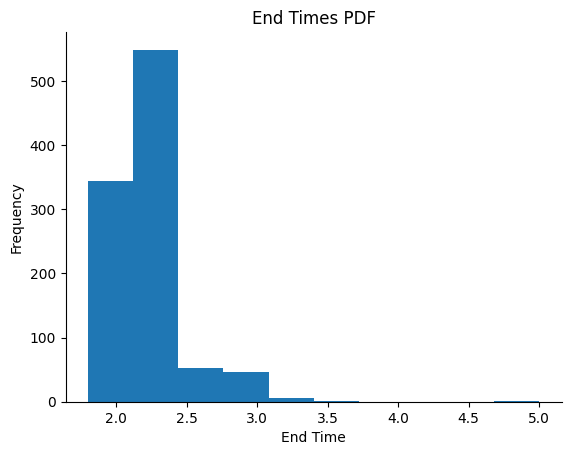

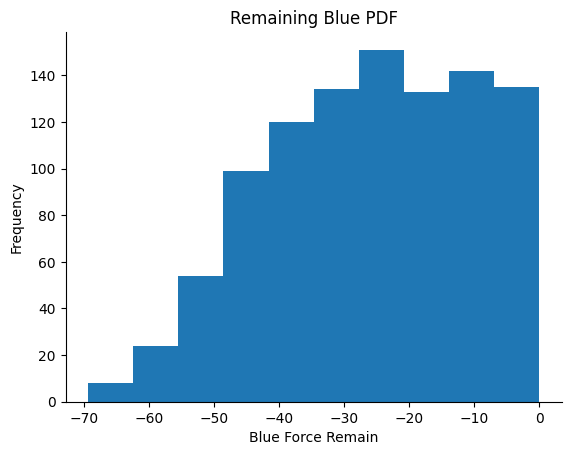

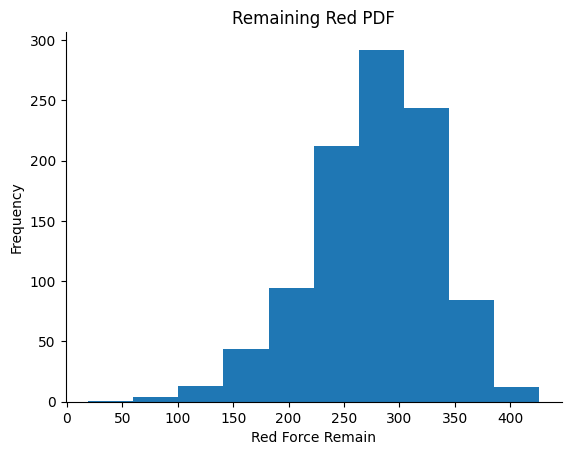

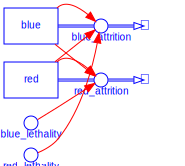

In [ ]:
from selib import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

number_runs = 1000

# vary manpower_buildup_parameter and estimated_total_effort in model definition

end_times = []  # initialize output data list
remaining_blue = [] # initialize output data list
remaining_red = [] # initialize output data list

for run in range(number_runs):
  # increase end time to allow simulation to run until one of the troops be eliminated
  init_sd_model ( start =0, stop =50 , dt = .2, stop_when="blue <= 0 or red <= 0")
  add_stock ("blue", 1000, outflows=["blue_attrition"])
  # if then else to stop attrition when zero troops and prevent negative troop
  add_flow ("blue_attrition", "if_then_else (blue > 0 , red * red_lethality , 0)")
  # add randomness to blue force lethality in uniform distribution between 0.7 and 0.9 for each time step
  add_auxiliary ("blue_lethality", "random_uniform(0.7,0.9)" )
  add_stock ("red", 1000, outflows =["red_attrition"])
  # if then else to stop attrition when zero troops and prevent negative troop
  add_flow ("red_attrition", "if_then_else (red > 0 , blue * blue_lethality , 0)")
  # add randomness to red force lethality in uniform distribution between 0.7 and 0.9 for each time step
  add_auxiliary ("red_lethality", "random_uniform(0.8,1)" )
  sim_results = run_model (verbose=False)
  end_times.append(get_stop_time())
  remaining_blue.append(sim_results["blue"].iloc[-1])
  remaining_red.append(sim_results["red"].iloc[-1])

def confidence_interval(data, confidence=0.95):
    #Calculates the confidence interval for the mean of a dataset.
    mean = np.mean(data)
    sem = st.sem(data)  # Standard error of the mean
    interval = st.t.interval(confidence, len(data) - 1, loc=mean, scale=sem)
    return interval

# Calculate confidence intervals
end_time_ci = confidence_interval(end_times)
remaining_blue_ci = confidence_interval(remaining_blue)
remaining_red_ci = confidence_interval(remaining_red)

# --- Output ---
print('Battle Result:')
for i, time in enumerate(end_times):
    print(f'  Run {i+1}: end {time} Remaining Blue Units {remaining_blue[i]:.2f} Remaining Red Units {remaining_red[i]:.2f}')

print("\n--- Confidence Intervals (95%) ---")
print(f"Mean Battle Duration: {np.mean(end_times):.2f}, CI: ({end_time_ci[0]:.2f}, {end_time_ci[1]:.2f})")
print(f"Mean Remaining Blue Units: {np.mean(remaining_blue):.2f}, CI: ({remaining_blue_ci[0]:.2f}, {remaining_blue_ci[1]:.2f})")
print(f"Mean Remaining Red Units: {np.mean(remaining_red):.2f}, CI: ({remaining_red_ci[0]:.2f}, {remaining_red_ci[1]:.2f})")

# --- Plotting ---
# End Times Histogram
fig, axis = plt.subplots()
axis.hist(end_times)
axis.set(title='End Times PDF', xlabel='End Time', ylabel='Frequency')
plt.show()  # Display the figure


# Remaining Blue Histogram
fig, axis = plt.subplots()
axis.hist(remaining_blue)
axis.set(title='Remaining Blue PDF', xlabel='Blue Force Remain', ylabel='Frequency')
plt.show()  # Display the figure


# Remaining Red Histogram
fig, axis = plt.subplots()
axis.hist(remaining_red)
axis.set(title='Remaining Red PDF', xlabel='Red Force Remain', ylabel='Frequency')
plt.show()  # Display the figure


# --- Model Diagram ---
draw_model_diagram()

# HW 6 Problem 2 Simulation

a. 1 & 2 Maintenance Facility Simulation

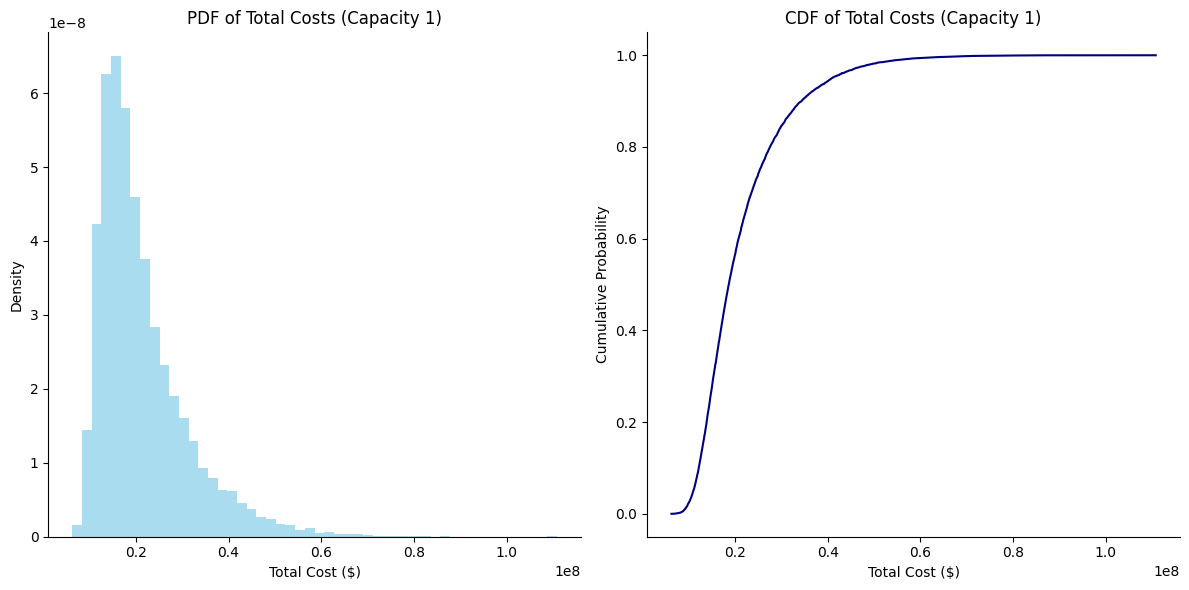

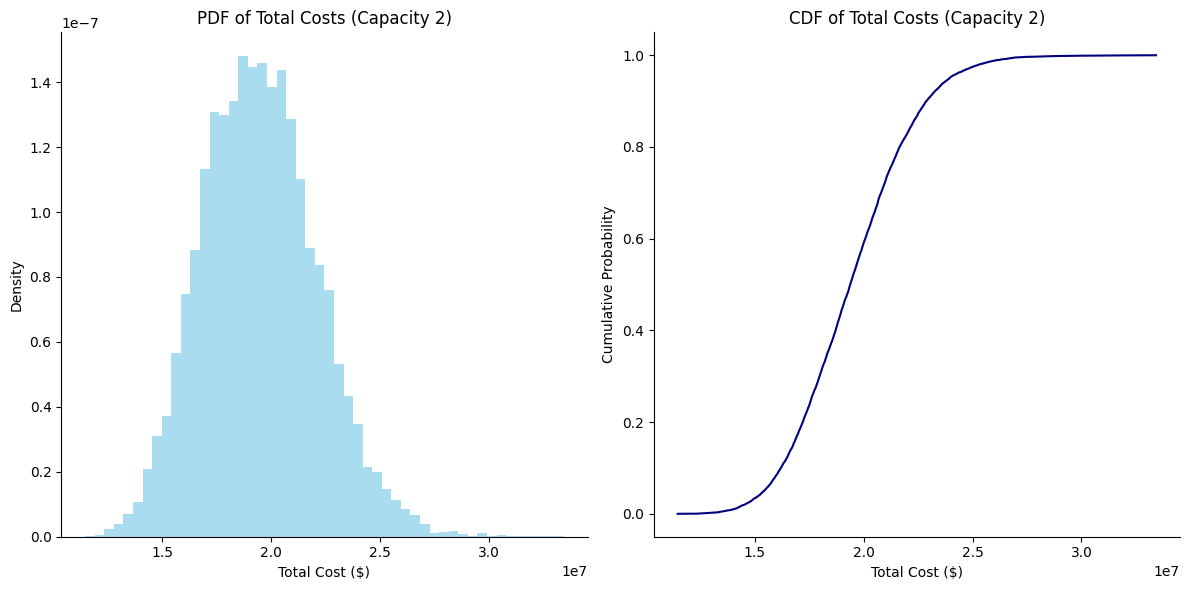

In [ ]:
from selib import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

#Monte Carlo Runs
number_runs = 10000

#Cost
cost_per_day = 250000
cost_per_wait_day = 500000

def run_simulation(capacity):
    end_times = []
    all_wait_times = []
    all_service_times = []
    total_costs = []

    for run in range(number_runs):
        init_de_model()

        add_source(name='incoming_ships',
                   entity_name="Ship",
                   num_entities=20,
                   connections={'maintenance facility': .5, 'no maintenance': .5},
                   interarrival_time='1')

        add_server(name='maintenance facility',
                   connections={'serviced ships': 1},
                   service_time='np.random.uniform(0.5, 3)',
                   capacity=capacity)

        add_terminate('serviced ships')
        add_terminate('no maintenance')

        model_data, entity_data = run_model(verbose=False)

        wait_times = model_data['maintenance facility']['waiting_times']
        service_times = model_data['maintenance facility']['service_times']

        end_time = max(entity['departure'] for entity in entity_data.values())

        all_wait_times.extend(wait_times)
        all_service_times.extend(service_times)
        end_times.append(end_time)

        # Calculate Total Cost
        total_cost = cost_per_day * capacity * end_time + cost_per_wait_day * (sum(wait_times) + sum(service_times))
        total_costs.append(total_cost)

    return total_costs


total_costs_capacity_1 = run_simulation(capacity=1)
total_costs_capacity_2 = run_simulation(capacity=2)



def plot_pdf_cdf(data, title):
    # PDF
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title(f'PDF of {title}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Density')

    # CDF
    plt.subplot(1, 2, 2)
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    plt.plot(sorted_data, yvals, color='navy')
    plt.title(f'CDF of {title}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Cumulative Probability')

    plt.tight_layout()
    plt.show()
#PDF & CDF plot for 1 & 2 maintenance facility
plot_pdf_cdf(total_costs_capacity_1, 'Total Costs (Capacity 1)')
plot_pdf_cdf(total_costs_capacity_2, 'Total Costs (Capacity 2)')

b. 1 & 2 Maintenance Facility Comparison

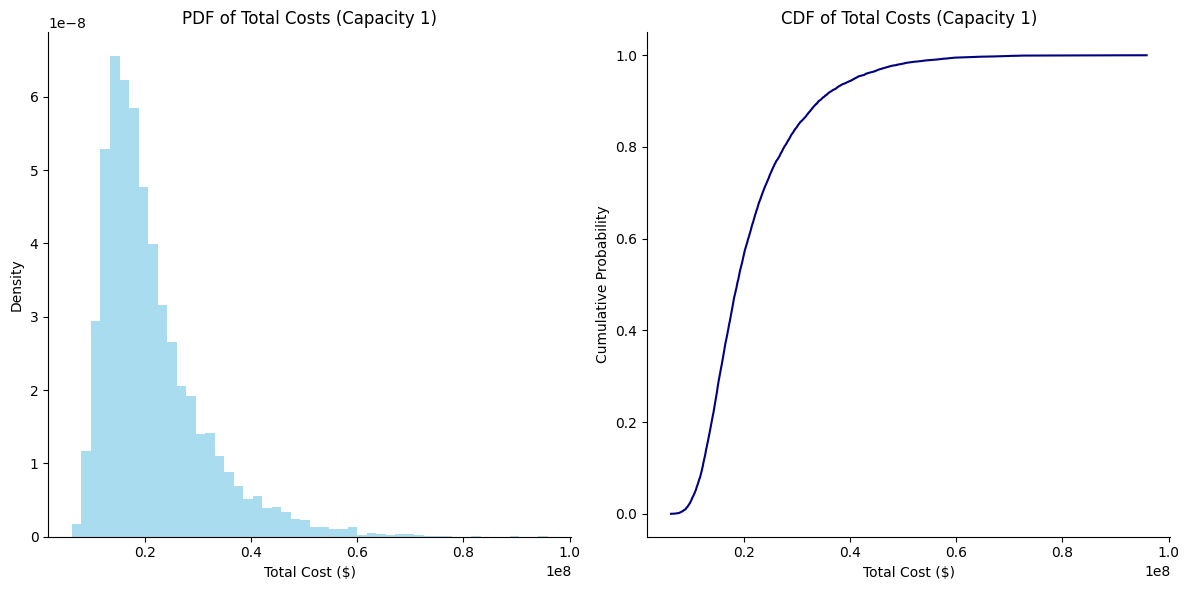

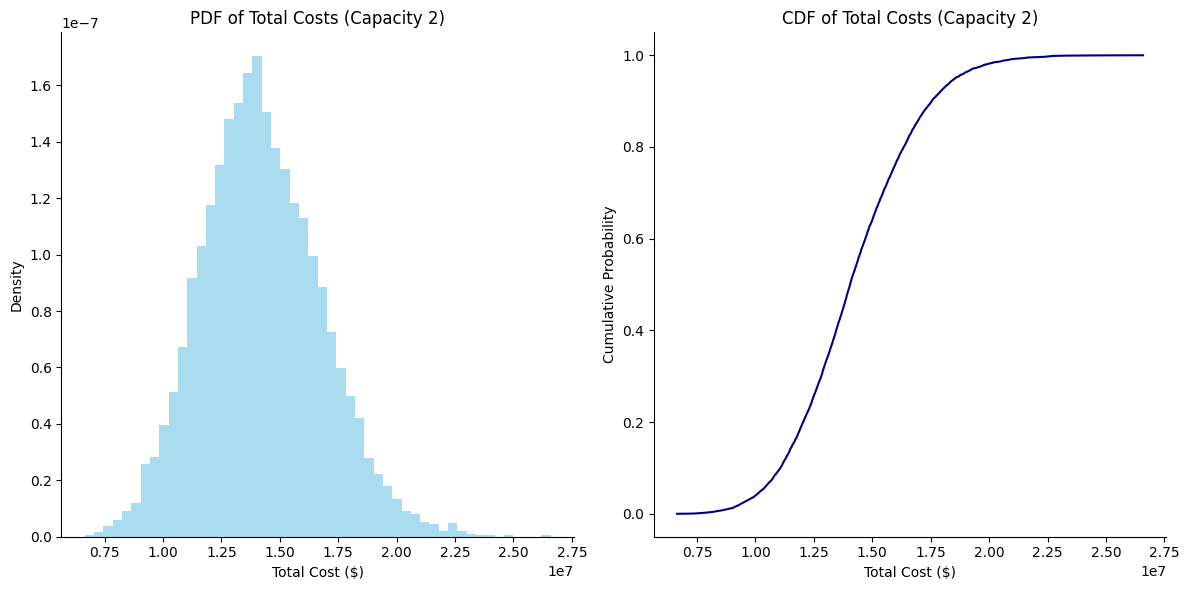


--- Hypothesis Testing ---
90% Confidence Interval for the difference between means: (7027220.82, 7357887.39)
Z Statistic: 71.56
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the means.


In [ ]:
from selib import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# --- Simulation Parameters ---
number_runs = 10000

# --- Simulation End Time ---
simulation_end_time = 20  # days

# --- Cost Parameters ---
cost_per_day = 250000
cost_per_wait_day = 500000

# --- Confidence Level ---
confidence_level = 0.90
alpha = 1 - confidence_level

# --- Function to Run Simulation for a Given Capacity ---
def run_simulation(capacity):
    end_times = []
    all_wait_times = []
    all_service_times = []
    total_costs = []

    for run in range(number_runs):
        init_de_model()

        add_source(name='incoming_ships',
                   entity_name="Ship",
                   num_entities=20,
                   connections={'maintenance facility': .5, 'no maintenance': .5},
                   interarrival_time='1')

        add_server(name='maintenance facility',
                   connections={'serviced ships': 1},
                   service_time='np.random.uniform(0.5, 3)',
                   capacity=capacity)

        add_terminate('serviced ships')
        add_terminate('no maintenance')

        model_data, entity_data = run_model(verbose=False)

        wait_times = model_data['maintenance facility']['waiting_times']
        service_times = model_data['maintenance facility']['service_times']

        end_time = max(entity['departure'] for entity in entity_data.values())

        all_wait_times.extend(wait_times)
        all_service_times.extend(service_times)
        if end_time <= simulation_end_time:
          end_times.append(end_time)

        # Calculate Total Cost
        total_cost = cost_per_day * end_time + cost_per_wait_day * (sum(wait_times) + sum(service_times))
        total_costs.append(total_cost)

    return total_costs


# --- Run Simulations for Capacities 1 and 2 ---
total_costs_capacity_1 = run_simulation(capacity=1)
total_costs_capacity_2 = run_simulation(capacity=2)

# --- Plotting Functions ---
def plot_pdf_cdf(data, title):
    # PDF
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title(f'PDF of {title}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Density')

    # CDF
    plt.subplot(1, 2, 2)
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    plt.plot(sorted_data, yvals, color='navy')
    plt.title(f'CDF of {title}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Cumulative Probability')

    plt.tight_layout()
    plt.show()

# --- Generate and Save Plots ---
plot_pdf_cdf(total_costs_capacity_1, 'Total Costs (Capacity 1)')
plot_pdf_cdf(total_costs_capacity_2, 'Total Costs (Capacity 2)')

# --- Hypothesis Testing ---

# Calculate sample statistics
mean_1 = np.mean(total_costs_capacity_1)
mean_2 = np.mean(total_costs_capacity_2)
std_1 = np.std(total_costs_capacity_1)
std_2 = np.std(total_costs_capacity_2)
n_1 = len(total_costs_capacity_1)
n_2 = len(total_costs_capacity_2)

# Calculate the pooled standard error
pooled_standard_error = np.sqrt((std_1**2 / n_1) + (std_2**2 / n_2))

# Calculate the Z test statistic
z_statistic = (mean_1 - mean_2) / pooled_standard_error

# Calculate the critical Z value for a two-tailed test
z_critical = st.norm.ppf(1 - alpha / 2)

# Calculate the confidence interval
margin_of_error = z_critical * pooled_standard_error
confidence_interval = (mean_1 - mean_2 - margin_of_error, mean_1 - mean_2 + margin_of_error)

# Perform the hypothesis test
p_value = 2 * (1 - st.norm.cdf(abs(z_statistic)))  # Two-tailed test

# Output the results
print("\n--- Hypothesis Testing ---")
print(f"90% Confidence Interval for the difference between means: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")
print(f"Z Statistic: {z_statistic:.2f}")
print(f"P-value: {p_value}")

# Determine if the null hypothesis is rejected
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

c. 1 & 2 Maintenance Facility Comparison with Exponential arrival time

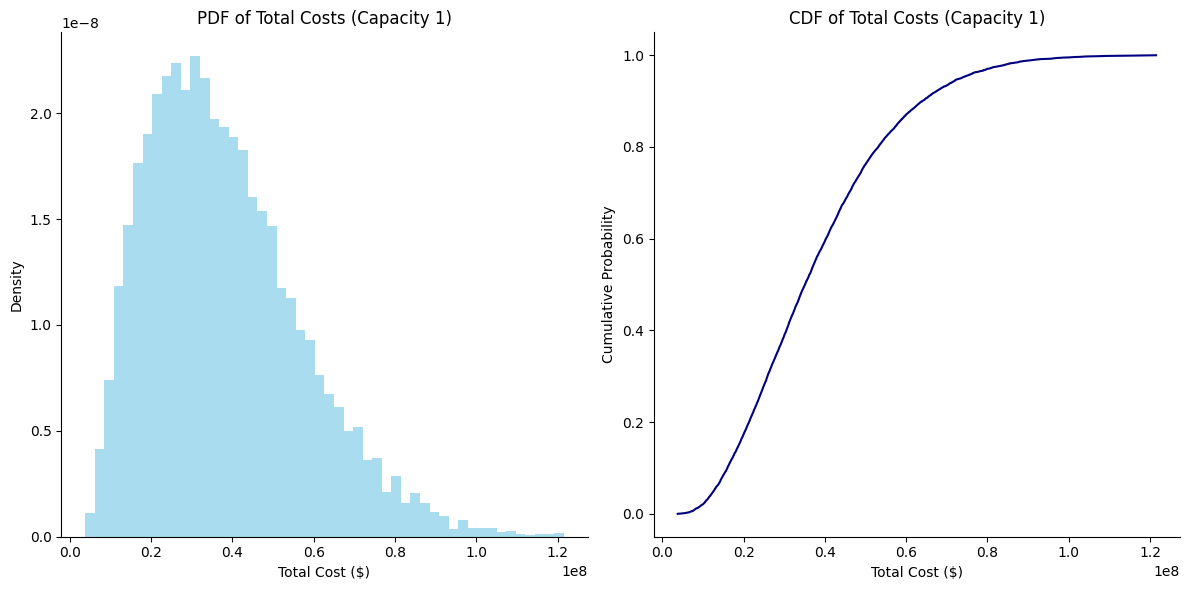

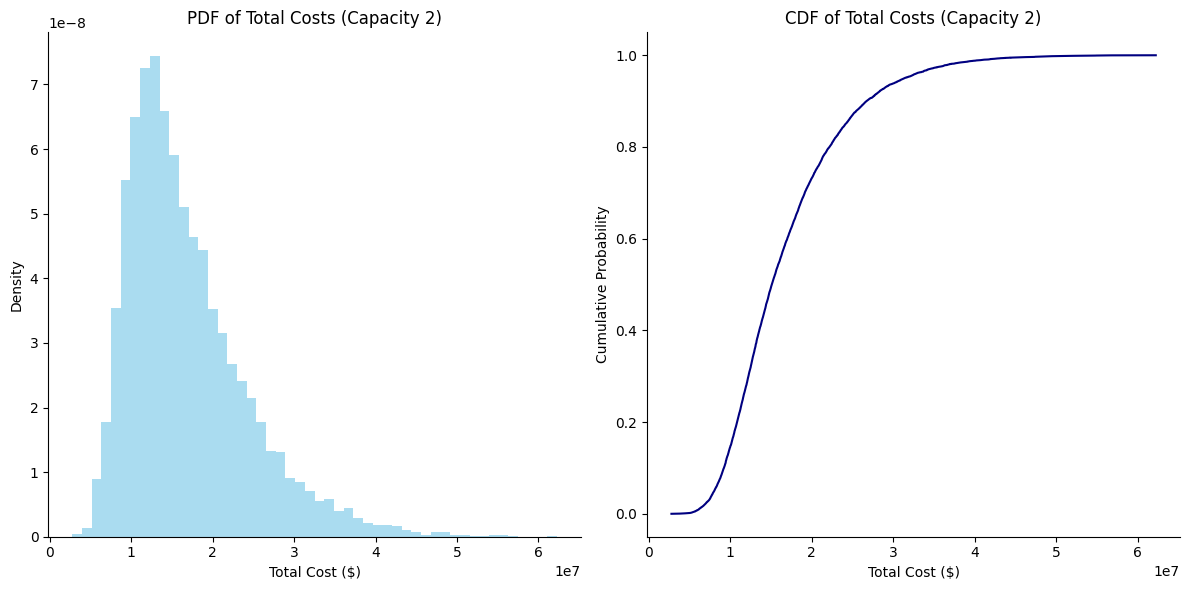


--- Hypothesis Testing ---
90% Confidence Interval for the difference between means: (20802514.10, 21469626.48)
Z Statistic: 104.23
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the means.


In [ ]:
from selib import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# --- Simulation Parameters ---
number_runs = 10000

# --- Simulation End Time ---
simulation_end_time = 20  # days

# --- Cost Parameters ---
cost_per_day = 250000
cost_per_wait_day = 500000

# --- Confidence Level ---
confidence_level = 0.90
alpha = 1 - confidence_level

# --- Function to Run Simulation for a Given Capacity ---
def run_simulation(capacity):
    end_times = []
    all_wait_times = []
    all_service_times = []
    total_costs = []

    for run in range(number_runs):
        init_de_model()

        add_source(name='incoming_ships',
                   entity_name="Ship",
                   num_entities=20,
                   connections={'maintenance facility': .5, 'no maintenance': .5},
                   interarrival_time='np.random.exponential(scale=10/24)')

        add_server(name='maintenance facility',
                   connections={'serviced ships': 1},
                   service_time='np.random.uniform(0.5, 3)',
                   capacity=capacity)

        add_terminate('serviced ships')
        add_terminate('no maintenance')

        model_data, entity_data = run_model(verbose=False)

        wait_times = model_data['maintenance facility']['waiting_times']
        service_times = model_data['maintenance facility']['service_times']

        end_time = max(entity['departure'] for entity in entity_data.values())

        all_wait_times.extend(wait_times)
        all_service_times.extend(service_times)
        if end_time <= simulation_end_time:
          end_times.append(end_time)

        # Calculate Total Cost
        total_cost = cost_per_day * end_time + cost_per_wait_day * (sum(wait_times) + sum(service_times))
        total_costs.append(total_cost)

    return total_costs


# --- Run Simulations for Capacities 1 and 2 ---
total_costs_capacity_1 = run_simulation(capacity=1)
total_costs_capacity_2 = run_simulation(capacity=2)

# --- Plotting Functions ---
def plot_pdf_cdf(data, title):
    # PDF
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=50, density=True, alpha=0.7, color='skyblue')
    plt.title(f'PDF of {title}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Density')

    # CDF
    plt.subplot(1, 2, 2)
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)
    plt.plot(sorted_data, yvals, color='navy')
    plt.title(f'CDF of {title}')
    plt.xlabel('Total Cost ($)')
    plt.ylabel('Cumulative Probability')

    plt.tight_layout()
    plt.show()

# --- Generate and Save Plots ---
plot_pdf_cdf(total_costs_capacity_1, 'Total Costs (Capacity 1)')
plot_pdf_cdf(total_costs_capacity_2, 'Total Costs (Capacity 2)')

# --- Hypothesis Testing ---

# Calculate sample statistics
mean_1 = np.mean(total_costs_capacity_1)
mean_2 = np.mean(total_costs_capacity_2)
std_1 = np.std(total_costs_capacity_1)
std_2 = np.std(total_costs_capacity_2)
n_1 = len(total_costs_capacity_1)
n_2 = len(total_costs_capacity_2)

# Calculate the pooled standard error
pooled_standard_error = np.sqrt((std_1**2 / n_1) + (std_2**2 / n_2))

# Calculate the Z test statistic
z_statistic = (mean_1 - mean_2) / pooled_standard_error

# Calculate the critical Z value for a two-tailed test
z_critical = st.norm.ppf(1 - alpha / 2)

# Calculate the confidence interval
margin_of_error = z_critical * pooled_standard_error
confidence_interval = (mean_1 - mean_2 - margin_of_error, mean_1 - mean_2 + margin_of_error)

# Perform the hypothesis test
p_value = 2 * (1 - st.norm.cdf(abs(z_statistic)))  # Two-tailed test

# Output the results
print("\n--- Hypothesis Testing ---")
print(f"90% Confidence Interval for the difference between means: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")
print(f"Z Statistic: {z_statistic:.2f}")
print(f"P-value: {p_value}")

# Determine if the null hypothesis is rejected
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")